<a href="https://colab.research.google.com/github/imiled/DL_Tools_For_Finance/blob/master/CNN_Transfer_Learning__teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google's Colab specific magic to avoid warnings and incompatibility issues (more info here https://colab.research.google.com/notebooks/tensorflow_version.ipynb)
%tensorflow_version 1.x

# Disable extremely annoying and boring warnings about tensorflow deprecation
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Transfer Learning in ConvNets

In essence, the idea behing transfer learning is to use pre-trained models as a starting point to solve another similar problem -- that is, don't re-invent the wheel and save computational efforts!

For doing transfer learning:

- First step entails gaining knowledge by training a neural network (typically a very deep one) on a given data. 
- Then, we transferred learned weights to any other neural network.
- Finally, we make small modification to fine tune the pre-existing model and fit it to our requirements. At this point, for instance, we can keep the weights of initial layers of the model frozen while we retrain only the higher (last append) layers.


Let's see an example :)

In [ ]:
import numpy as np
import pylab as plt

from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


### Example using CIFAR-10

Let’s begin by loading the dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print("There are {} train images and {} test images.".format(X_train.shape[0], X_test.shape[0]))
print('There are {} unique classes to predict.'.format(np.unique(y_train).shape[0]))

170500096/170498071 [==============================] - 11s 0us/step
There are 50000 train images and 10000 test images.
There are 10 unique classes to predict.


Next, we will one-hot encode our train and test labels.

In [ ]:
num_classes = 10

y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

and visualize some images of our training data

Shape of each image in the training data:  (32, 32, 3)


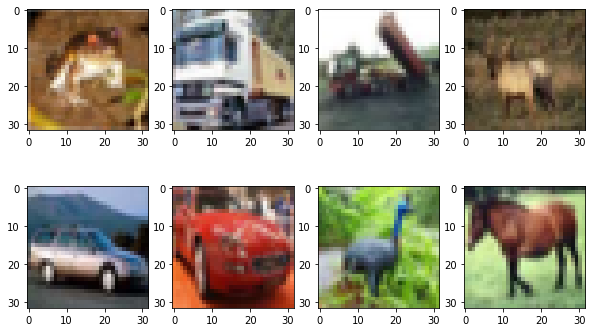

In [ ]:
fig = plt.figure(figsize=(10, 6))

for i in range(8):
    img = X_train[i]
    fig.add_subplot(2, 4, i+1)
    plt.imshow(img)


print('Shape of each image in the training data: ', X_train.shape[1:])

Let's normalize the data:

In [ ]:
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)

(50000, 32, 32, 3)


Now, build a model from scratch:

In [ ]:
#Building up a Sequential model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)               

Model training:

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

#Fitting the model on the train data and labels.
model.fit(X_train, y_train, batch_size=32, epochs=10, 
          verbose=1, validation_split=0.2, shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 48s 1ms/step - loss: 0.2616 - acc: 0.9037 - val_loss: 0.2356 - val_acc: 0.9076
Epoch 2/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.2215 - acc: 0.9136 - val_loss: 0.2103 - val_acc: 0.9177
Epoch 3/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.2040 - acc: 0.9204 - val_loss: 0.2040 - val_acc: 0.9209
Epoch 4/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.1922 - acc: 0.9249 - val_loss: 0.1868 - val_acc: 0.9276
Epoch 5/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.1824 - acc: 0.9288 - val_loss: 0.1818 - val_acc: 0.9292
Epoch 6/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.1750 - acc: 0.9320 - val_loss: 0.1835 - val_acc: 0.9286
Epoch 7/10
40000/40000 [==============================] - 47s 1ms/step - loss: 0.1683 - acc: 0.9344 - val_loss: 0.1765 - val_acc

Model evaluation:

In [ ]:
#Evaluate the model on the test data
score = model.evaluate(X_test, y_test)

#Accuracy on test data
print('Accuracy on the Test Images: ', score[1])

10000/10000 [==============================] - 3s 350us/step
Accuracy on the Test Images:  0.9341799957275391


### Transfer Learning

Time to implement transfer learning and check if we can improve the model :)

We will be using the vgg16 model pre-trained on the Imagenet weights. 

**Note:** Take care of the input dimensions! The default input size for vgg16 network is 224x224. So you can either adapt your images to this size (using skimage.transform.resize for instance) or you should specify the ```input_shape``` parameter of vgg16 with the correct dimensions of your images -- ```(32,32,3)``` in this case. In this notebook we work with this last scenario.


**Note:** we will remove the fully connected layers of the pre-trained network near the end using ```include_top = False```. Then we can grow the network with other layers


**Note:** As commented in the introduction, we will keep vgg part fixed and we will train just the new layers. Otherwise:

- To set as trainable part of the vgg model you can do:

```
# For instance, do block5 trainable:
for layer in your_model.layers[0].layers:
    if 'block5' in layer.name: 
        layer.trainable = True
    else: 
        layer.trainable = False
```

- To set the vgg model as a whole to trainable, do:

```
your_model.layers[0].trainable = True
```



In [ ]:
#Importing the VGG16 model
from keras.applications.vgg16 import VGG16, preprocess_input

#Loading the VGG16 model with pre-trained ImageNet weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_model.trainable = False # remove if you want to retrain vgg weights

vgg_model.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

Add few layers on top of the network:

In [ ]:
transfer_model = Sequential()
transfer_model.add(vgg_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dropout(0.2))
transfer_model.add(Dense(10, activation='softmax'))

transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 14,781,642
Trainable params: 66,954
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Print the VGG16 model info (inside our model):
transfer_model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
#If you prefer to reshape the training and test data:
#from skimage.transform import resize
#X_train_new = np.array([resize(X_train[i], (224, 224)) for i in range(0, len(X_train))]).astype('float32')
#X_test_new = np.array([resize(X_test[i], (224, 224)) for i in range(0, len(X_test))]).astype('float32')

# Otherwise:
X_train_new = X_train
X_test_new = X_test

#Preprocessing the data, so that it can be fed to the pre-trained vgg16 model. 
X_train_new = preprocess_input(X_train_new)
X_test_new = preprocess_input(X_test_new)

y_train_new = y_train
y_test_new = y_test

In [ ]:
batch_size=32
epochs=50

In [ ]:
transfer_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

history = transfer_model.fit(X_train_new, y_train_new, \
                              batch_size=batch_size, epochs=epochs, \
                              validation_split=0.2, verbose=1, shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 529s 13ms/step - loss: 2.3229 - acc: 0.1785 - val_loss: 2.0805 - val_acc: 0.2191
Epoch 2/50
40000/40000 [==============================] - 529s 13ms/step - loss: 2.0810 - acc: 0.2287 - val_loss: 2.0071 - val_acc: 0.2501
Epoch 3/50
40000/40000 [==============================] - 527s 13ms/step - loss: 2.0478 - acc: 0.2437 - val_loss: 2.0106 - val_acc: 0.2610
Epoch 4/50
40000/40000 [==============================] - 526s 13ms/step - loss: 2.0233 - acc: 0.2525 - val_loss: 1.9745 - val_acc: 0.2842
Epoch 5/50
40000/40000 [==============================] - 525s 13ms/step - loss: 2.0082 - acc: 0.2588 - val_loss: 1.9660 - val_acc: 0.2917
Epoch 6/50
40000/40000 [==============================] - 525s 13ms/step - loss: 1.9963 - acc: 0.2630 - val_loss: 1.9305 - val_acc: 0.2933
Epoch 7/50
39968/40000 [============================>.] - ETA: 0s - loss: 1.9898 - acc: 0.2677

In [ ]:
#Evaluate the model on the test data
score  = transfer_model.evaluate(X_test_new, y_test_new)

#Accuracy on test data
print('Accuracy on the Test Images: ', score[1])

Not so good... can we perform the training better? Try to solve the next exercises :)

**Exercise 0:** Find the bug in the code. Hint: are images properly loaded in the network?

**Exercise 1:** Play with other final architectures

**Exercise 2:** Train partially (or fully) vgg16 and compare the results

**Exercise 3:** Select just a part of vgg16 architecture as input of your model

**Exercise 4:** Play with other deep cnn architectures (InceptionV3, resnet50, etc)

**Exercise 5:** Finally, play with other datasets

## References

https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

http://cs231n.github.io/transfer-learning/

https://www.hackerearth.com/fr/practice/machine-learning/transfer-learning/transfer-learning-intro/tutorial/



# Some solutions

Solution to Exercise 0:

In the following two lines we are preprocessing input images

```python
X_train_new = preprocess_input(X_train_new)
X_test_new = preprocess_input(X_test_new)
```

but those arrays were already preprocessed here

```python
X_train = X_train/255.
X_test = X_test/255.
```

to fix this, just load the data again.

```python
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
```
